In [ ]:
"""
Imports, with path adjustment if necessary.
"""

import os
directory_changed = False
try:
    from simulations.drosselschwab import simulate_drosselschwab
except:
    print("Adjusting path for imports...")
    os.chdir("..")
    directory_changed = True
    from simulations.drosselschwab import simulate_drosselschwab

print(os.getcwd())

from scipy.interpolate import interp1d
import results
import data
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing
import pandas as pd
import csv
import os
from pathlib import Path
from datetime import datetime
from scripts.parallel_sims import worker
import numpy as np
import json
import csv
import re
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
import numpy as np
import pandas as pd
from pathlib import Path
import numpy as np
import powerlaw
import matplotlib.pyplot as plt

if directory_changed:
    base_dir = Path("/experiment_1").resolve()
else:
    base_dir = Path("/experiment_1").resolve()

Adjusting path for imports...
/home/ijsbrand/CMS/CS/Project/CSS_project-19


In [10]:
cwd = Path.cwd()
print("CWD:", cwd)
print("Working directory should be own_directory/experiment_1")
change_directory = input("If directory is not correct type desired path")
if change_directory != "":
    os.chdir(change_directory)
cwd = Path.cwd()
print("New directory:", cwd)

files = list(cwd.rglob("*"))
print("Total files seen:", len(files))

"""
Function that reads three dataframes.
"""
def find_three_datasets(idx):
    files = list(Path.cwd().rglob(f"perstep_param{idx}_*.csv"))
    print("Number of files found:", len(files), end=" ")
    print("for index:", idx)
    if len(files) != 3:
        raise ValueError("Less than three files found, check given index or directory")
    df1 = pd.read_csv(files[0])
    df2 = pd.read_csv(files[1])
    df3 = pd.read_csv(files[2])
    return df1, df2, df3
df1, df2, df3 = find_three_datasets(1)

CWD: /home/ijsbrand/CMS/CS/Project/experiment_1
Working directory should be own_directory/experiment_1
New directory: /home/ijsbrand/CMS/CS/Project/experiment_1
Total files seen: 148
Number of files found: 3 for index: 1


The following cell is used to create an average of the three cells. The df contain a column for the fire sizes and the mean tree density. The standard average is taken for the mean tree densisty. The fire sizes are concatinated.

In [19]:

"""
Function that takes three dataframes from per-step simulation results
and averages them into a single dataframe.

Each dataframe is expected to have columns:
- "fire_size": a JSON-encoded list of fire sizes for that step
- "mean tree density": a float representing the mean tree density at that step
Returns a new dataframe with columns:
- "fire_sizes": a flattened list of fire sizes from all three dataframes for each step
"""

def avg_df_3(df1, df2, df3):
    dfs = [df1, df2, df3]
    n_steps = min(len(df) for df in dfs)

    rows = []

    for i in range(n_steps):
        fire_lists = []
        for df in dfs:
            x = df.iloc[i]["fire_size"]
            if isinstance(x, str):
                x = json.loads(x) if x else []
            fire_lists.append(x)

        # flatten into a single list
        fire_sizes_step = list(chain.from_iterable(fire_lists))

        # average tree density (fix column name too!)
        tree_density_step = np.mean(
            [df.iloc[i]["mean tree density"] for df in dfs]
        )

        rows.append({
            "fire_sizes": fire_sizes_step,
            "tree_density": tree_density_step,
        })


    avg_df = pd.DataFrame(rows)
    avg_df.head()
    return avg_df

def plot_average_tree_density(densities, ax=None, label=None):
    if ax is None:
        ax = plt.gca()

    ax.plot(densities, label=label)
    ax.set_xlabel("Time step")
    ax.set_ylabel("Average tree density")
    ax.set_title("Average tree density over time")

    return ax

def plot_fire_size_distribution(fire_sizes_col, label=None, nbins=25, density=True):
    sizes = np.fromiter(chain.from_iterable(fire_sizes_col), dtype=np.int64)

    smin, smax = sizes.min(), sizes.max()
    bins = np.logspace(np.log10(smin), np.log10(smax), nbins + 1)

    counts, edges = np.histogram(sizes, bins=bins)

    centers = np.sqrt(edges[:-1] * edges[1:])

    if density:
        widths = edges[1:] - edges[:-1]
        pdf = counts / (counts.sum() * widths)
        y = pdf
        ylabel = "Probability density"
    else:
        pmf = counts / counts.sum()
        y = pmf
        ylabel = "Probability"

    m = counts > 0
    plt.loglog(centers[m], y[m], marker="o", linestyle="-", label=label)

    plt.xlabel("Fire size")
    plt.ylabel(ylabel)

In [20]:
def flatten_fire_sizes(series):
    """Flatten a pandas Series of lists/arrays into a 1D numpy int array."""
    arrs = []
    for lst in series:
        if isinstance(lst, (list, np.ndarray)) and len(lst) > 0:
            arrs.append(np.asarray(lst, dtype=int).ravel())
    if not arrs:
        return np.array([], dtype=int)
    x = np.concatenate(arrs)
    x = x[np.isfinite(x)]
    x = x[x > 0]
    return x

def empirical_ccdf(data_1d):
    """Empirical CCDF for 1D array (returns unique x and P(X>=x))."""
    data = np.asarray(data_1d)
    data = data[np.isfinite(data)]
    data = data[data > 0]
    if data.size == 0:
        return np.array([]), np.array([])
    data = np.sort(data)

    x = np.unique(data)
    # counts of >= x using searchsorted (fast)
    idx = np.searchsorted(data, x, side="left")
    ccdf = (data.size - idx) / data.size
    return x, ccdf

### Different f values

Number of files found: 3 for index: 17
Number of files found: 3 for index: 18
Number of files found: 3 for index: 19
Number of files found: 3 for index: 20
Number of files found: 3 for index: 21


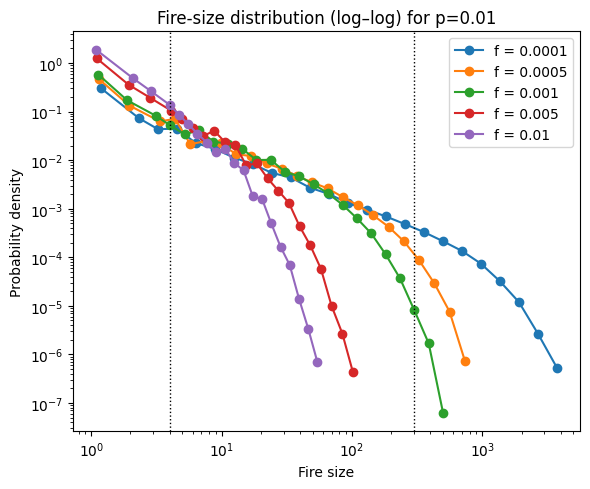

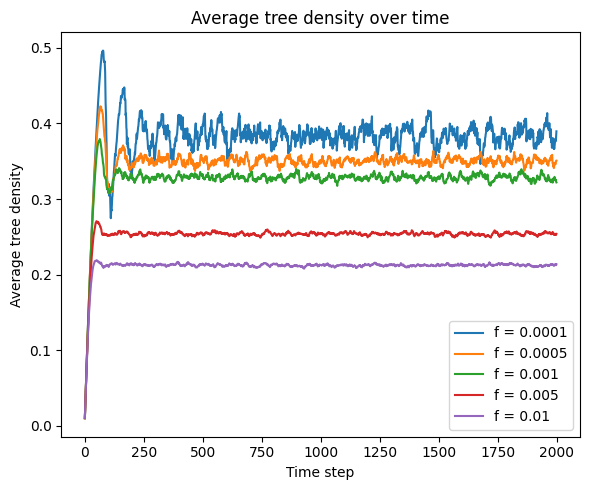

In [21]:
# Selected indexes and corresponding f values with fixed p=0.01
indexes = [17, 18, 19, 20, 21]
f_values = [0.0001, 0.0005, 0.001, 0.005, 0.01]
avg_dfs = [avg_df_3(*find_three_datasets(i)) for i in indexes]
plt.figure(figsize=(6, 5))

for i, df in enumerate(avg_dfs):
    plot_fire_size_distribution(
        df["fire_sizes"],
        label=f"f = {f_values[i]}",
        nbins=25,
        density=True
    )

plt.title("Fire-size distribution (log–log) for p=0.01")
plt.legend()
plt.tight_layout()

plt.axvline(4, color="k", linestyle=":", linewidth=1)
plt.axvline(300, color="k", linestyle=":", linewidth=1)

plt.show()

fig, ax = plt.subplots(figsize=(6, 5))

for i, df in enumerate(avg_dfs):
    plot_average_tree_density(
        df["tree_density"].to_numpy(),
        ax=ax,
        label=f"f = {f_values[i]}",
    )

ax.legend()
fig.tight_layout()
plt.show()

### Different p values

Using p values: [0.2, 0.02, 0.01, 0.001]
Number of files found: 3 for index: 44
Number of files found: 3 for index: 25
Number of files found: 3 for index: 19
Number of files found: 3 for index: 7


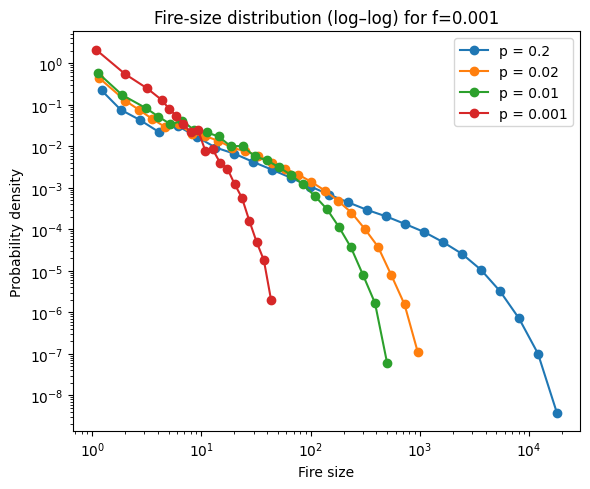

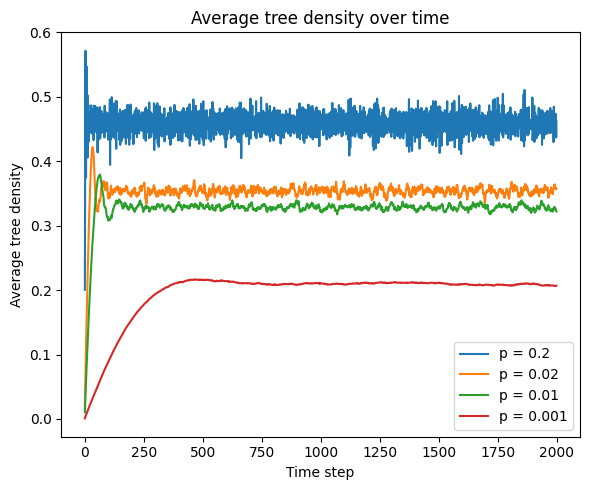

In [17]:
indexes = [7, 19, 25, 44]
indexes.reverse()
p_values = [0.001, 0.01, 0.02, 0.2]
p_values.reverse()
print("Using p values:", p_values)
avg_dfs = [avg_df_3(*find_three_datasets(i)) for i in indexes]
plt.figure(figsize=(6, 5))

for i, df in enumerate(avg_dfs):
    plot_fire_size_distribution(
        df["fire_sizes"],
        label=f"p = {p_values[i]}",
        nbins=25,
        density=True
    )

plt.title("Fire-size distribution (log–log) for f=0.001")
plt.legend()
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(6, 5))

for i, df in enumerate(avg_dfs):
    plot_average_tree_density(
        df["tree_density"].to_numpy(),
        ax=ax,
        label=f"p = {p_values[i]}",
    )

ax.legend()
fig.tight_layout()
plt.show()

### Different f/p ratio's

Number of files found: 3 for index: 1
Number of files found: 3 for index: 3
Number of files found: 3 for index: 5
Number of files found: 3 for index: 7
Number of files found: 3 for index: 15
Number of files found: 3 for index: 17
Number of files found: 3 for index: 19
Number of files found: 3 for index: 21
Number of files found: 3 for index: 29
Number of files found: 3 for index: 31
Number of files found: 3 for index: 33
Number of files found: 3 for index: 35


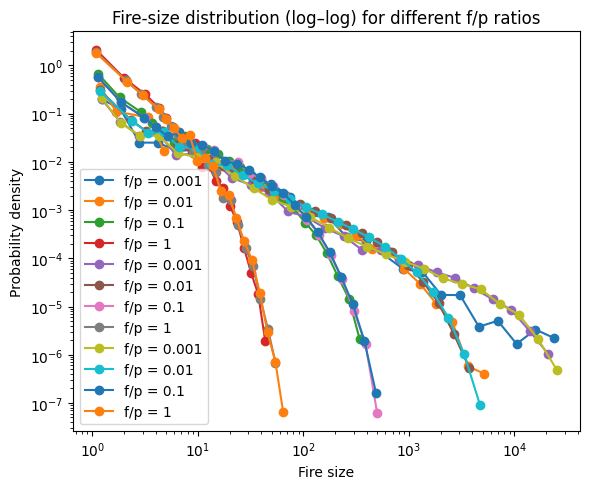

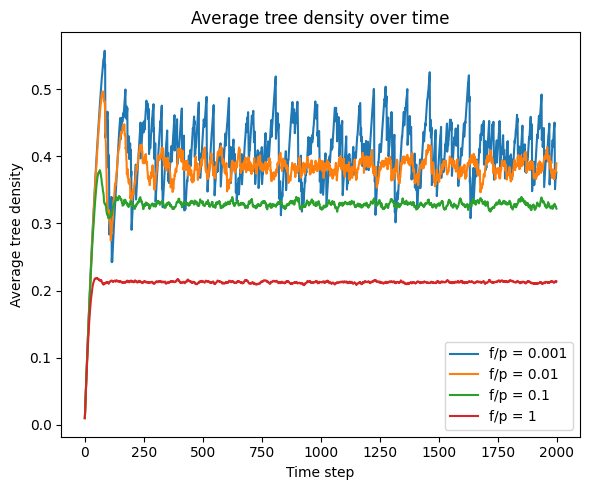

In [24]:
indexes = [1, 3, 5, 7, 15, 17, 19, 21, 29, 31, 33, 35]
f_over_p = [0.001, 0.01, 0.1, 1] * 3

avg_dfs = [avg_df_3(*find_three_datasets(i)) for i in indexes]
plt.figure(figsize=(6, 5))

for i, df in enumerate(avg_dfs):
    plot_fire_size_distribution(
        df["fire_sizes"],
        label=f"f/p = {f_over_p[i]}",
        nbins=25,
        density=True
    )

plt.title("Fire-size distribution (log–log) for different f/p ratios")
plt.legend()
plt.tight_layout()
plt.show()

avg_dfs = avg_dfs[4:8]
fig, ax = plt.subplots(figsize=(6, 5))

for i, df in enumerate(avg_dfs):
    plot_average_tree_density(
        df["tree_density"].to_numpy(),
        ax=ax,
        label=f"f/p = {f_over_p[i]}",
    )

ax.legend()
fig.tight_layout()
plt.show()

### From visual to concrete data
In this section we will use the powerlaw package to perform test to see if we are working with powerlaws.

Number of files found: 3 for index: 29
Number of files found: 3 for index: 31
Number of files found: 3 for index: 33
Number of files found: 3 for index: 35


/home/ijsbrand/CMS/CS/Project/.venv/lib/python3.11/site-packages/powerlaw/distributions.py:808: UserWarning: Fitted parameters are very close to the edge of parameter ranges for distribution truncated_power_law; consider changing these ranges.
  warnings.warn(f'Fitted parameters are very close to the edge of parameter ranges for distribution {self.name}; consider changing these ranges.')



=== f/p = 1 ===
PL vs TPL: R= -1201.099055783743 p= 0.0
TPL vs LN: R= 466.26317756376164 p= 4.837414530137615e-215
xmin: 3.0
alpha (pure PL): 1.2485071907384593
alpha (truncated): 1.028722984802528
lambda (cutoff rate): 6.0417648254617555e-05


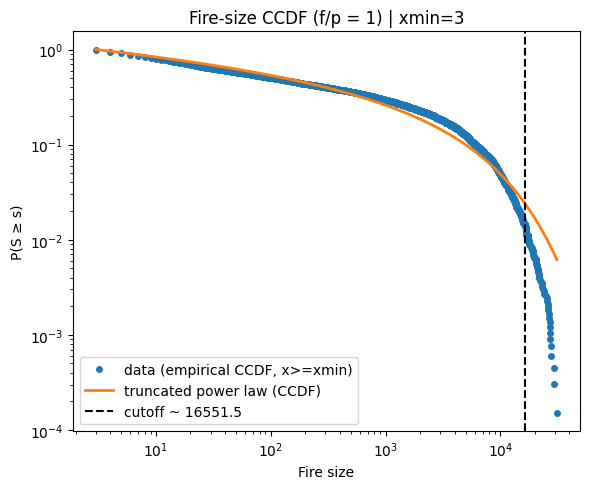

/home/ijsbrand/CMS/CS/Project/.venv/lib/python3.11/site-packages/powerlaw/distributions.py:808: UserWarning: Fitted parameters are very close to the edge of parameter ranges for distribution truncated_power_law; consider changing these ranges.
  warnings.warn(f'Fitted parameters are very close to the edge of parameter ranges for distribution {self.name}; consider changing these ranges.')



=== f/p= 0.1  ===
PL vs TPL: R= -447.53665915240197 p= 0.0
TPL vs LN: R= 18.03401464800052 p= 1.3011949237210407e-05
xmin: 555.0
alpha (pure PL): 2.755504296534324
alpha (truncated): 0.2962683821125305
lambda (cutoff rate): 0.001690276805480321


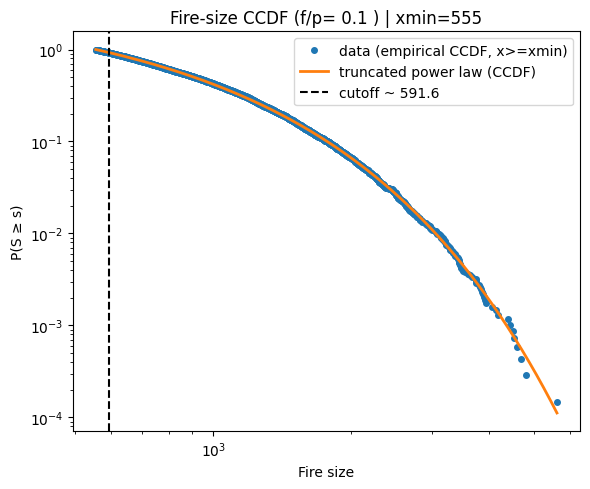

/home/ijsbrand/CMS/CS/Project/.venv/lib/python3.11/site-packages/powerlaw/distributions.py:743: OptimizeWarning: Initial guess is not within the specified bounds
  result = scipy.optimize.minimize(fit_function,



=== f/p = 0.01 ===
PL vs TPL: R= -3797.2941739462985 p= 0.0
TPL vs LN: R= 110.75449836755003 p= 1.2648617746196575e-19
xmin: 52.0
alpha (pure PL): 2.9817581919964815
alpha (truncated): 0.4866333853850191
lambda (cutoff rate): 0.02017483677242404


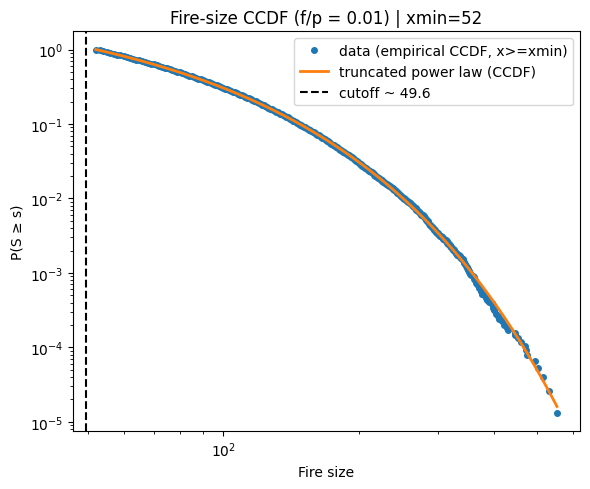

/home/ijsbrand/CMS/CS/Project/.venv/lib/python3.11/site-packages/powerlaw/distributions.py:743: OptimizeWarning: Initial guess is not within the specified bounds
  result = scipy.optimize.minimize(fit_function,



=== f/p = 0.001 ===
PL vs TPL: R= -67287.7050445932 p= 0.0
TPL vs LN: R= 1778.1070959894807 p= 6.660715939112051e-259
xmin: 5.0
alpha (pure PL): 2.872998046875
alpha (truncated): 0.35638451564468315
lambda (cutoff rate): 0.22079289990365952


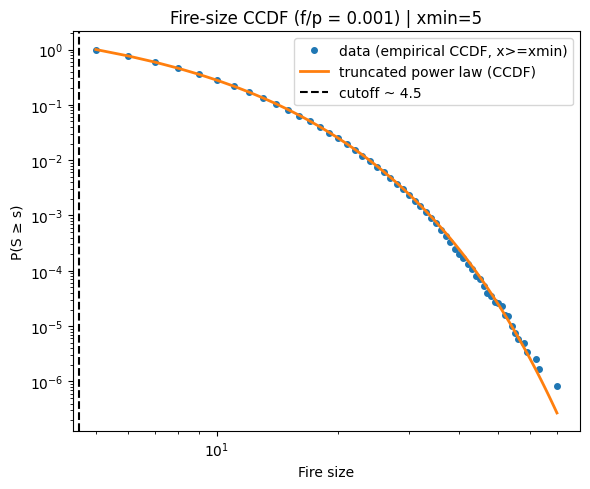

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import powerlaw



indexes = [29, 31, 33, 35]
datasets = ["f/p = 1", "f/p= 0.1 " ,"f/p = 0.01", "f/p = 0.001"]

avg_dfs = [avg_df_3(*find_three_datasets(i)) for i in indexes]

for i, df in enumerate(avg_dfs):
    fire_sizes = flatten_fire_sizes(df["fire_sizes"])
    if fire_sizes.size < 50:
        print(f"f/p={f_over_p[i]}: not enough data after flattening")
        continue

    # ---- Fit (on unbinned raw data) ----
    fit = powerlaw.Fit(fire_sizes, discrete=True, verbose=False)

    # ---- Model comparisons ----
    R, p = fit.distribution_compare("power_law", "truncated_power_law")
    R2, p2 = fit.distribution_compare("truncated_power_law", "lognormal")

    print(f"\n=== {datasets[i]} ===")
    print("PL vs TPL: R=", R, "p=", p)
    print("TPL vs LN: R=", R2, "p=", p2)
    print("xmin:", fit.xmin)
    print("alpha (pure PL):", fit.power_law.alpha)
    print("alpha (truncated):", fit.truncated_power_law.alpha)
    print("lambda (cutoff rate):", fit.truncated_power_law.Lambda)

    # ---- Tail-only empirical CCDF (x >= xmin) ----
    xmin = int(fit.xmin)
    tail = fire_sizes[fire_sizes >= xmin]

    x_emp, ccdf_emp = empirical_ccdf(tail)

    # ---- Model CCDF on the same x-grid ----
    # (use integer grid spanning the observed tail)
    x_model = np.arange(int(x_emp.min()), int(x_emp.max()) + 1)
    ccdf_tpl = fit.truncated_power_law.ccdf(x_model)

    # ---- Plot ----
    plt.figure(figsize=(6, 5))
    plt.loglog(x_emp, ccdf_emp, "o", markersize=4, label="data (empirical CCDF, x>=xmin)")
    plt.loglog(x_model, ccdf_tpl, "-", linewidth=2, label="truncated power law (CCDF)")

    cutoff = 1.0 / fit.truncated_power_law.Lambda
    plt.axvline(cutoff, ls="--", color="k", label=f"cutoff ~ {cutoff:.1f}")

    plt.xlabel("Fire size")
    plt.ylabel("P(S ≥ s)")
    plt.title(f"Fire-size CCDF ({datasets[i]}) | xmin={xmin}")
    plt.legend()
    plt.tight_layout()
    plt.show()

Each of the analysis strongly points to a truncated power law or lognormal (no significant difference). We see that the cutoff values increases as the f/p ratio grows. This gives us the impression that the scale-free characteristic of the fire-sizes get lost at high f/p, and so SOC behavior is absent.

#### Data Collapse

The next cell will perform a data collapse.
First we will try to fit $\tau$, with the relation $P(s) \sim s^{-\tau}$ on the observed data.  $\\$
We use the data before the cutoff on the plots above, which follow a power-law, see the dotted lines.  $\\$
Now we find a cutoff value $f_c$ for each curve, we chose the 99% percentile. $\\$
Then we rescale our data with the following value:
$$P(s;f) = s^{-\tau} F(\frac{s}{f_c})$$

Number of files found: 3 for index: 29
Number of files found: 3 for index: 31
Number of files found: 3 for index: 33
Number of files found: 3 for index: 35
Estimated tau ≈ 1.16


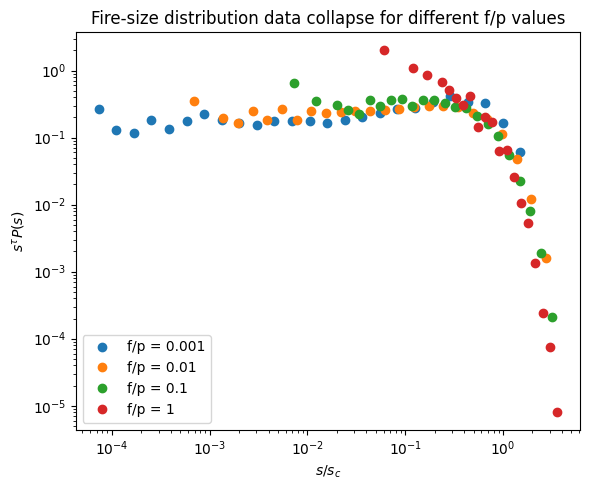

In [31]:
"""
First try at data collapsing
"""
def sc_quantile(fire_sizes_col, q=0.99):
    # cutoff ~ largest observed fire size
    sizes = np.fromiter(chain.from_iterable(fire_sizes_col), dtype=np.int64)
    sizes = sizes[sizes > 0]
    return np.quantile(sizes, q)


"""
Fire_size_histogram:
input: column of fire sizes (lists)

outpt:
- centers: bin centers
- y: probability density or mass
"""

indexes = [29, 31, 33, 35]
f_over_p = [0.001, 0.01, 0.1, 1]
avg_dfs = [avg_df_3(*find_three_datasets(i)) for i in indexes]

def fire_size_histogram(fire_sizes_col, nbins=25, density=True):
    sizes = np.fromiter(chain.from_iterable(fire_sizes_col), dtype=np.int64)
    sizes = sizes[sizes > 0]

    smin, smax = sizes.min(), sizes.max()
    bins = np.logspace(np.log10(smin), np.log10(smax), nbins + 1)

    counts, edges = np.histogram(sizes, bins=bins)
    centers = np.sqrt(edges[:-1] * edges[1:])

    m = counts > 0
    centers = centers[m]
    counts = counts[m]

    if density:
        widths = edges[1:] - edges[:-1]
        widths = widths[m]
        y = counts / (counts.sum() * widths)
    else:
        y = counts / counts.sum()

    return centers, y

s, p = fire_size_histogram(avg_dfs[0]["fire_sizes"])

#See chosen cutoff lines in previous plot
mask = (s > 4) & (s < 300)

log_s = np.log10(s[mask])
log_p = np.log10(p[mask])

slope, intercept = np.polyfit(log_s, log_p, 1)
tau = -slope

print(f"Estimated tau ≈ {tau:.2f}")

plt.figure(figsize=(6, 5))

curves = []

for i, df in enumerate(avg_dfs):
    s, p = fire_size_histogram(df["fire_sizes"])

    sc = sc_quantile(df["fire_sizes"])

    x = s / sc
    y = (s ** tau) * p
    curves.append((x, y))

    plt.loglog(x, y, 'o', label=f"f/p = {f_over_p[i]}")

plt.xlabel(r"$s / s_c$")
plt.ylabel(r"$s^{\tau} P(s)$")
plt.title("Fire-size distribution data collapse for different f/p values")
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
def mean_log_scatter(curves, x_min=None, x_max=None, n=80):
    # auto overlap if not provided
    if x_min is None or x_max is None:
        xmin_list, xmax_list = [], []
        for x, y in curves:
            m = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
            xmin_list.append(x[m].min())
            xmax_list.append(x[m].max())
        x_min = max(xmin_list)
        x_max = min(xmax_list)

    if not (x_min < x_max):
        return np.nan

    xg = np.logspace(np.log10(x_min), np.log10(x_max), n)

    Ys = []
    for x, y in curves:
        m = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
        x, y = x[m], y[m]
        if len(x) < 2:
            continue

        order = np.argsort(x)
        x, y = x[order], y[order]

        m2 = (x >= x_min) & (x <= x_max)
        x, y = x[m2], y[m2]
        if len(x) < 2:
            continue

        yg = np.interp(np.log10(xg), np.log10(x), np.log10(y), left=np.nan, right=np.nan)
        Ys.append(yg)

    if len(Ys) < 2:
        return np.nan
    Y = np.vstack(Ys)
    return np.nanmean(np.nanstd(Y, axis=0))

scatter = mean_log_scatter(curves)
print("Mean log-scatter:", scatter)

Mean log-scatter: 0.16943007184607964


We see a log-scatter mean that is in the range of 0.2-0.3. From which we can conclude a succesfull data collaps. So the fire-size distribution obeys finite-size scaling. And the choice of f/p influences the cutoff, with a universal scaling function.

In [34]:
from pathlib import Path
import ast
#os.chdir("../../experiment_1")
cwd = Path.cwd()
print("CWD:", cwd)

files = list(cwd.rglob("*"))
print("Total files seen:", len(files))

def combine_cluster_distr(files, id_col="step", list_col="cluster distr"):
    dfs = []
    for f in files[:3]:
        df = pd.read_csv(f, usecols=[id_col, list_col]).copy()
        df["cluster distr"] = df["cluster distr"].map(
        lambda s: np.fromstring(s.strip("[]"), sep=",", dtype=int).tolist()
            )
        dfs.append(df)

    # merge with unique suffixes per file
    def merge_two(left, right, idx):
        return left.merge(right, on=id_col, how="inner", suffixes=("", f"__{idx}"))

    merged = dfs[0]
    for idx, d in enumerate(dfs[1:], start=1):
        merged = merge_two(merged, d, idx)

    # collect all list columns (original + suffixed) and flatten row-wise
    list_cols = [c for c in merged.columns if c.startswith(list_col)]
    merged[list_col] = merged[list_cols].apply(
        lambda r: list(chain.from_iterable(r)),
        axis=1
    )

    return merged[[id_col, list_col]]

"""
Function that reads three dataframes.
"""
def find_clust_distr(idx):
    files = list(Path.cwd().rglob(f"perstep_param{idx}_*.csv"))
    print("Number of files found:", len(files), end=" ")
    print("for index:", idx)
    if len(files) < 3:
        raise ValueError("Less than three files found, check given index")
    return combine_cluster_distr(files)



type(df1["cluster distr"].iloc[0])

df1.head()

CWD: /home/ijsbrand/CMS/CS/Project/experiment_1
Total files seen: 148


,step,fire_size,cluster distr,mean tree density
0,0,[],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.001144
1,1,[],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, ...",0.002029
2,2,[],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.003220
3,3,[],"[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.004303
4,4,[],"[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, ...",0.005081


Number of files found: 3 for index: 29
Number of files found: 3 for index: 31
Number of files found: 3 for index: 33
Number of files found: 3 for index: 35


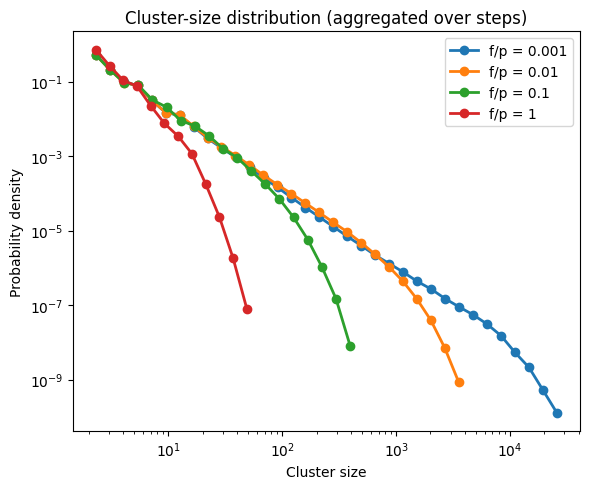

In [35]:
import numpy as np
import matplotlib.pyplot as plt


def logbin_pdf(values, bins_per_decade=8):
    values = np.asarray(values, dtype=float)
    values = values[np.isfinite(values)]
    values = values[values > 0]
    if values.size == 0:
        return np.array([]), np.array([])

    xmin, xmax = values.min(), values.max()
    nbins = max(1, int(np.ceil((np.log10(xmax) - np.log10(xmin)) * bins_per_decade)))
    edges = np.logspace(np.log10(xmin), np.log10(xmax), nbins + 1)

    counts, edges = np.histogram(values, bins=edges)
    widths = np.diff(edges)
    centers = np.sqrt(edges[:-1] * edges[1:])

    pdf = counts / (counts.sum() * widths)
    m = counts > 0
    return centers[m], pdf[m]

plt.figure(figsize=(6, 5))
indexes = [29, 31, 33, 35]
f_over_p = [0.001, 0.01, 0.1, 1]
for i, idx in enumerate(indexes):
    df = find_clust_distr(idx)
    # aggregate all steps into one long array
    all_sizes = np.concatenate(df["cluster distr"].values)

    # (optional) drop size-1 clusters if you wan
    all_sizes = all_sizes[all_sizes > 1]

    x, y = logbin_pdf(all_sizes, bins_per_decade=8)

    plt.plot(x, y, marker="o", linewidth=2, label=f"f/p = {f_over_p[i]}")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Cluster size")
    plt.ylabel("Probability density")
    plt.title("Cluster-size distribution (aggregated over steps)")
    plt.legend()
    plt.tight_layout()
plt.show()

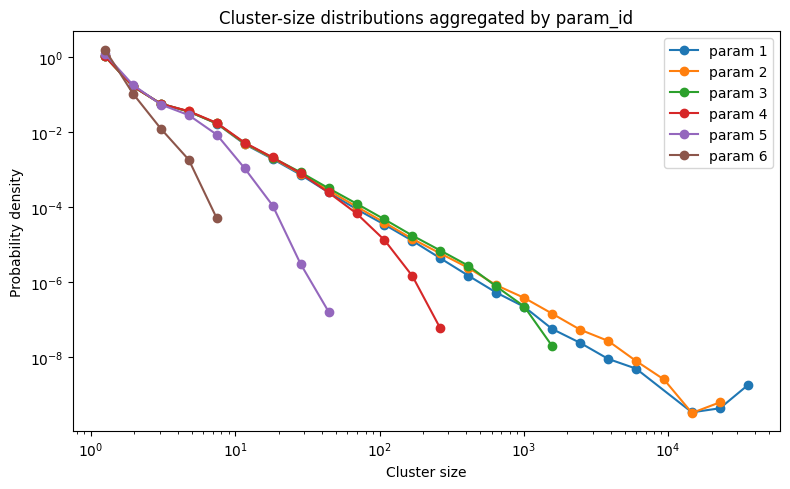